In [122]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import datasets, linear_model, neighbors
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score,StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
from collections import Counter
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')



cancer_df = pd.read_csv("wdbc.data.csv", header = None)
cancer_df.shape

bc_data = datasets.load_breast_cancer()
bc_data # Headers are present in feature_names
headers = bc_data['feature_names']

print('Columns =',len(cancer_df.columns)) # 32 columns
headers = np.append(['id', 'target'], headers)

cancer_df.columns = headers
cancer_df['target'] = pd.Series(np.where(cancer_df['target'] == 'M', 1, 0))
cancer_df.head() # Dataset ready

Columns = 32


,id,target,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


The data has been prepared and the dependent variable has been identified. The Dependent varibale is called target.
Newt we split the data into test and training set to start building a model.
We use a 90/10 train test split. As we will be using Nested cross validation we need to provide as much data as possible to our training set.

## Test Train Split

In [9]:
X_train,X_test,y_train,y_test = train_test_split(cancer_df.iloc[:,2:],cancer_df.iloc[:,1],test_size = .1 , random_state = 64, stratify = cancer_df.iloc[:,1])

Nest we scale the data. As we will be using models such as SVM and logistic we need to normalise the data to prevent some features from dominating our model. Here we use a standard scaler with a Min-Max Scaling.

## Normalizing the Data

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We will set up our code to enter the models we want to run and also the hyperparameters we want to tune the models on.

We run 4 models on the data.
We start with SVM and hypertune to find the best kernel , C and gamma. We use linear and rbf for kernel.
Next we run the KNN model, we tune it on the features n_neighbors, weights.
Next with the decision tree we train the model. We use parameters criterion and max_depth.
Last we run the logistic regression model on the data. we use parameters C, penalty and multi_class.

In [46]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(m["model"])[:3])
    
    plt.legend()
    plt.show()

In [68]:
random_state_models = 64
svm = SVC(probability = True,random_state = random_state_models)
knn = KNeighborsClassifier()
dtc = tree.DecisionTreeClassifier(random_state = random_state_models)
log = linear_model.LogisticRegression(solver ='newton-cg',random_state = random_state_models)

NUM_TRIALS = 1

p_grid = {1:{"model": svm, "hyperparam": {"kernel": ["linear","rbf"] ,"C": [0.01, 0.1, 1, 10, 100],"gamma": [.01, .1, 1, 10, 100]}},
          2:{"model": knn,"hyperparam":{"n_neighbors": list(range(1,31)), "weights": ["uniform", "distance"]}},
          3:{"model": dtc,"hyperparam":{"criterion": ["entropy","gini"], "max_depth": list(range(1,10)),"min_samples_leaf": range(5, 15), "min_samples_split": range(5, 15)}},
          4:{"model": log,"hyperparam":{"C":[.001,.01,.1,1,10,100,1000,10000],"penalty":["l2"],"multi_class" : ["ovr","multinomial"]}}}
        

Next we run all the models using nested Grid Cross Validation. We run the entire code for 10 random states to get the best generalised model.

We also plot the lift and ROC curve for each model.

DT AUC: 0.99


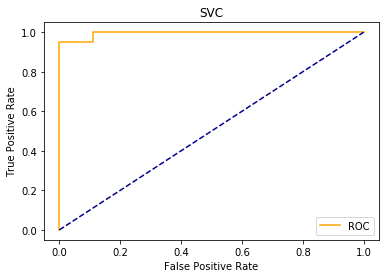

DT AUC: 0.96


<Figure size 432x288 with 0 Axes>

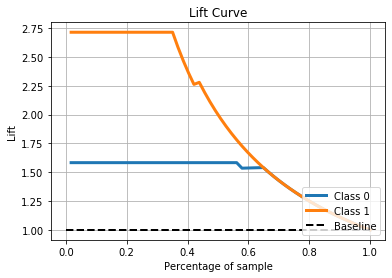

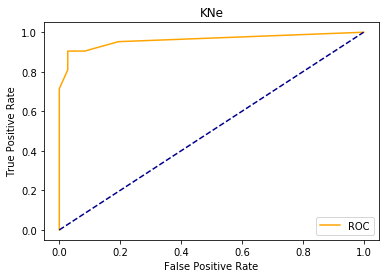

DT AUC: 0.88


<Figure size 432x288 with 0 Axes>

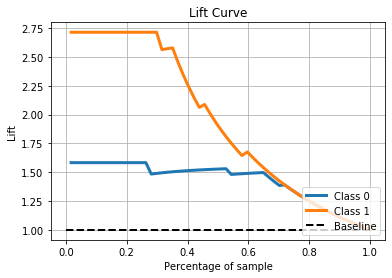

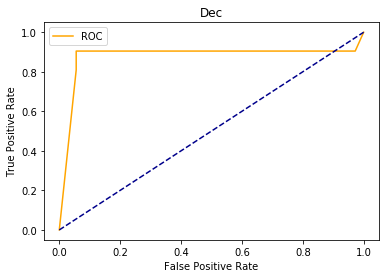

DT AUC: 1.00


<Figure size 432x288 with 0 Axes>

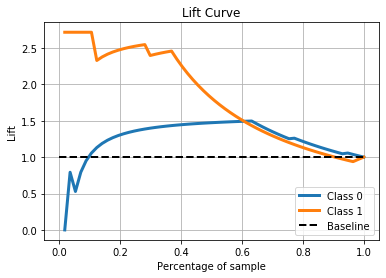

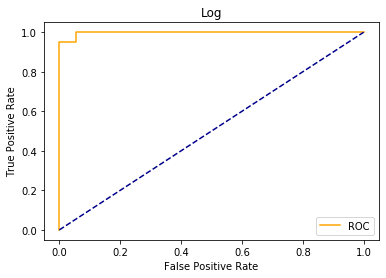

<Figure size 432x288 with 0 Axes>

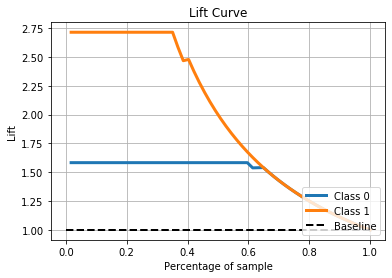

In [120]:
performance_metrix = {}
performance = np.zeros(len(p_grid))
n = 1
fpr =[]
tpr = []
threshold = []
i=2
y_pred =[]
plot = []
p = []
# We will use a Support Vector Classifier with "rbf" kernel

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)


# Loop for each trial
for m in p_grid.values():
    non_nested_scores = np.zeros(NUM_TRIALS)
    nested_scores = np.zeros(NUM_TRIALS)
    

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    #inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=m["model"], param_grid=m["hyperparam"], cv=inner_cv)
    clf.fit(X_train,y_train)
    performance_metrix[n] = {"non_nested_scores":{i:clf.best_score_}}
    non_nested_scores = clf.best_score_

   # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_train, y=y_train, cv=outer_cv)
    nested_scores = nested_score.mean() 
    y_pred = clf.predict(X_test)
    

    performance_metrix[n] = {"Non_nested_scores" : non_nested_scores, 
                              "Nested_scores" : nested_scores,
                          "Score_Diff" : non_nested_scores - nested_score,
                             
                             "BEST_PARAM" : clf.best_params_,"Accuracy": clf.best_score_,
                              "BEST_MODEL" : clf.best_estimator_,
                             "Testing_accuracy":  accuracy_score(y_test, y_pred),
                            "performance" :{'F1-Score': metrics.f1_score(y_test, y_pred),
     'Precision': metrics.precision_score(y_test, y_pred),
     'Recall': metrics.recall_score(y_test, y_pred),
     'Accuracy': metrics.accuracy_score(y_test, y_pred),
     'Kappa Score': metrics.cohen_kappa_score(y_test, y_pred)}}
    
    
    
    clf1_prob = clf.predict_proba(X_test)
   
    
    clf_prob = clf1_prob[:,1]
    
    auc_dt = roc_auc_score(y_test, clf_prob)
    print('DT AUC: %.2f' % auc_dt)

    fpr, tpr, thresholds = roc_curve(y_test, clf_prob)
    
    
    f = plt.figure(1)
    plot_roc_curve(fpr, tpr)
    f.show()
    a = plt.figure(2)
    skplt.metrics.plot_lift_curve(y_test, clf1_prob)
    a.show()
    n=n+1
   # print("Average difference of {0:6f} with std. dev. of {1:6f}."
   #   .format(score_difference.mean(), score_difference.std()))
   # performance_metrix[m["model"]] = {"BEST_PARAM" : clf.best_params_}
#performance_metrix[m["model"]] = {"BEST_MODEL" : clf.best_estimator_}

In [121]:
performance_metrix

{1: {'Non_nested_scores': 0.9765625,
  'Nested_scores': 0.9726399173304645,
  'Score_Diff': array([ 0.00757025,  0.0078125 , -0.015625  ,  0.01593258]),
  'BEST_PARAM': {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'},
  'Accuracy': 0.9765625,
  'BEST_MODEL': SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
      max_iter=-1, probability=True, random_state=64, shrinking=True, tol=0.001,
      verbose=False),
  'Testing_accuracy': 0.9824561403508771,
  'performance': {'F1-Score': 0.975609756097561,
   'Precision': 1.0,
   'Recall': 0.9523809523809523,
   'Accuracy': 0.9824561403508771,
   'Kappa Score': 0.9619238476953907}},
 2: {'Non_nested_scores': 0.97265625,
  'Nested_scores': 0.9628742923304645,
  'Score_Diff': array([0.003664  , 0.01171875, 0.01171875, 0.01202633]),
  'BEST_PARAM': {'n_neighbors': 5, 'weights': 'uniform'},
  'Accuracy': 0.97265625,
  'BEST_MODEL': KNeighborsClassifier(algorithm='auto'

In [41]:
matrix = {"SVM": performance_metrix[1]["performance"],
          "KNN": performance_metrix[2]["performance"],
          "Decision Tree": performance_metrix[3]["performance"],
          "Logistic": performance_metrix[4]["performance"] }
measuring_martix = pd.DataFrame(data = matrix)
measuring_martix

,SVM,KNN,Decision Tree,Logistic
Accuracy,0.947368,0.947368,0.964912,0.964912
F1-Score,0.923077,0.926829,0.952381,0.950000
Kappa Score,0.883436,0.885772,0.924603,0.923077
Precision,1.000000,0.950000,0.952381,1.000000
Recall,0.857143,0.904762,0.952381,0.904762


Looking at the above table we see that the accuracy of logistic regression is the highest of the lot. Logistic also provides the best F1-Score,Kappa Score,Precision and recall. Hence we choose logistic regression with parameters {'C': .1, 'multi_class': 'ovr', 'penalty': 'l2'} to classify  this dataset.

5) Among the basic classification techniques that you are familiar with (i.e., decision tree, k-NN, logistic regression, NB, SVM) use all that would be applicable to this dataset to predict the evaluation of the cars based on their characteristics. Explore how well these techniques perform for several different parameter values. Present a brief overview of your predictive modeling process, explorations, and discuss your results. Present your final model (i.e., the best predictive model that you were able to come up with), and discuss its performance in a comprehensive manner (overall accuracy; per-class performance, i.e., whether this model predicts all classes equally well, or if there some classes for which it does much better than others; etc.).(What are pros and cons?) You can try building your models both ways; which demonstrate better predictive performance?

In [41]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import datasets, linear_model, neighbors
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score,StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
from collections import Counter
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import scikitplot as skplt
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings('ignore')

In [42]:
data = pd.read_csv("car.data", header = None)
data # Headers need to be changed
headers = np.array(["buying_price", "maintenance_price", 'doors', "capacity", "boot_size", "safety", "evaluation"])
data.columns = headers
data.head()
target = data['evaluation']
X = data.iloc[:,0:6]
X.head()
target.head()

0    unacc
1    unacc
2    unacc
3    unacc
4    unacc
Name: evaluation, dtype: object

In [43]:
# Replacing characters in car_class to numbers
data['buying_price'] = data['buying_price'].replace({'low': 1, 'med': 2, 'high': 3, 'vhigh': 4})
data['maintenance_price'] = data['maintenance_price'].replace({'low': 1, 'med': 2, 'high': 3, 'vhigh': 4})
data['doors'] = pd.to_numeric(data['doors'].replace({'5more': 5}))
data['capacity'] = pd.to_numeric(data['capacity'].replace({'more': 6}))
data['boot_size'] = data['boot_size'].replace({'small': 1, 'med': 2, 'big': 3})
data['safety'] = data['safety'].replace({'low': 1, 'med': 2, 'high': 3})

# Splitting data into dependent and independent variables
X_data = data.iloc[:, :6]
y_data = data.iloc[:, 6]

In [44]:
X.dtypes

buying_price         object
maintenance_price    object
doors                object
capacity             object
boot_size            object
safety               object
dtype: object

The data has been prepared and the dependent variable has been identified. The Dependent varibale is called target.
Newt we split the data into test and training set to start building a model.
We use a 90/10 train test split. As we will be using Nested cross validation we need to provide as much data as possible to our training set.



In [45]:
## Test Train Split

X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size = .1 , random_state = 64, stratify = y_data)


### Running the models by considering the data as numeric

In [46]:
random_state_models = 64
svm = SVC(probability = True,random_state = random_state_models)
knn = KNeighborsClassifier()
dtc = tree.DecisionTreeClassifier(random_state = random_state_models)
log = linear_model.LogisticRegression(solver ='newton-cg',random_state = random_state_models)
nbc = MultinomialNB()
NUM_TRIALS = 1

p_grid = {1:{"model": svm, "hyperparam": {'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}},
          2:{"model": knn,"hyperparam":{"n_neighbors": list(range(1,31)), "weights": ["uniform", "distance"]}},
          3:{"model": dtc,"hyperparam":{"criterion": ["entropy","gini"], "max_depth": list(range(1,10)),"min_samples_leaf": range(5, 15), "min_samples_split": range(5, 15)}},
          4:{"model": log,"hyperparam":{"C":[.001,.01,.1,1,10,100,1000,10000],"penalty":["l2"],"multi_class" : ["ovr","multinomial"]}},
          5:{"model": nbc,"hyperparam":{"alpha": [0.001, 0.01, 0.1, 1, 10]}}}
        

In [ ]:
performance_metrix = {}

n = 1
fpr =[]
tpr = []
threshold = []
i=2
y_pred =[]
plot = []
p = []


# Loop for each trial
for m in p_grid.values():
    non_nested_scores = np.zeros(NUM_TRIALS)
    nested_scores = np.zeros(NUM_TRIALS)
    

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
    #inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=m["model"], param_grid=m["hyperparam"], cv=inner_cv)
    clf.fit(X_train,y_train)
    non_nested_scores = clf.best_score_

   # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_train, y=y_train, cv=outer_cv)
    nested_scores = nested_score.mean() 
    y_pred = clf.predict(X_test)
    

    performance_metrix[n] = {"Non_nested_scores" : non_nested_scores, 
                              "Nested_scores" : nested_scores,
                          "Score_Diff" : non_nested_scores - nested_score,
                             "BEST_PARAM" : clf.best_params_,"Accuracy": clf.best_score_,
                              "BEST_MODEL" : clf.best_estimator_,
                             "Testing_accuracy":  accuracy_score(y_test, y_pred),
                            "performance" :{'F1-Score': metrics.f1_score(y_test, y_pred,average = 'micro'),
     'Precision': metrics.precision_score(y_test, y_pred,average = 'micro' ),
     'Recall': metrics.recall_score(y_test, y_pred,average = 'micro'),
     'Accuracy': metrics.accuracy_score(y_test, y_pred),
     'Kappa Score': metrics.cohen_kappa_score(y_test, y_pred)}}
    n=n+1 
    
    skplt.metrics.plot_roc(y_test, clf.predict_proba(X_test), plot_micro=False, plot_macro=False)
    plt.title(str(m["model"])[:3])
    


/Users/raftel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/raftel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [56]:

performance_metrix

{1: {'Non_nested_scores': 0.9678456591639871,
  'Nested_scores': 0.963982987761908,
  'Score_Diff': array([-0.00259136,  0.0103167 ]),
  'BEST_PARAM': {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'},
  'Accuracy': 0.9678456591639871,
  'BEST_MODEL': SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, probability=True, random_state=64, shrinking=True, tol=0.001,
      verbose=False),
  'Testing_accuracy': 0.9942196531791907,
  'performance': {'F1-Score': 0.9942196531791907,
   'Precision': 0.9942196531791907,
   'Recall': 0.9942196531791907,
   'Accuracy': 0.9942196531791907,
   'Kappa Score': 0.9874900571263288}},
 2: {'Non_nested_scores': 0.9170418006430868,
  'Nested_scores': 0.9099628456954936,
  'Score_Diff': array([-0.00069599,  0.0148539 ]),
  'BEST_PARAM': {'n_neighbors': 5, 'weights': 'distance'},
  'Accuracy': 0.9170418006430868,
  'BEST_MODEL': KNeighborsClassifier(algorithm='auto', leaf

In [57]:
matrix1 = {"SVM": performance_metrix[1]["performance"],
          "KNN": performance_metrix[2]["performance"],
          "Decision Tree": performance_metrix[3]["performance"],
          "Logistic": performance_metrix[4]["performance"],
         "Naive Bayes": performance_metrix[5]["performance"]}
measuring_martix = pd.DataFrame(data = matrix1)
measuring_martix

,SVM,KNN,Decision Tree,Logistic,Naive Bayes
Accuracy,0.99422,0.953757,0.924855,0.838150,0.693642
F1-Score,0.99422,0.953757,0.924855,0.838150,0.693642
Kappa Score,0.98749,0.898860,0.838585,0.651811,-0.000764
Precision,0.99422,0.953757,0.924855,0.838150,0.693642
Recall,0.99422,0.953757,0.924855,0.838150,0.693642


Here we see that SVM has the best performance in all the criterions. Its Accuracy precsion recall is almost 1 hence it is able to predict each and every class in our dependent variable with almost perfect accuracy.

### Running the models by considering the data as categorical

### Converting the data into categorical

In [63]:
X = pd.get_dummies(X_data)

In [64]:
## Test Train Split

X_train,X_test,y_train,y_test = train_test_split(X,y_data,test_size = .1 , random_state = 64, stratify = y_data)


In [66]:
random_state_models = 64
svm = SVC(probability = True,random_state = random_state_models)
knn = KNeighborsClassifier()
dtc = tree.DecisionTreeClassifier(random_state = random_state_models)
log = linear_model.LogisticRegression(solver ='newton-cg',random_state = random_state_models)
nbc = MultinomialNB()
NUM_TRIALS = 1

p_grid = {1:{"model": svm, "hyperparam": {'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}},
          2:{"model": knn,"hyperparam":{"n_neighbors": list(range(1,31)), "weights": ["uniform", "distance"]}},
          3:{"model": dtc,"hyperparam":{"criterion": ["entropy","gini"], "max_depth": list(range(1,10)),"min_samples_leaf": range(5, 15), "min_samples_split": range(5, 15)}},
          4:{"model": log,"hyperparam":{"C":[.001,.01,.1,1,10,100,1000,10000],"penalty":["l2"],"multi_class" : ["ovr","multinomial"]}},
          5:{"model": nbc,"hyperparam":{"alpha": [0.001, 0.01, 0.1, 1, 10]}}}
        

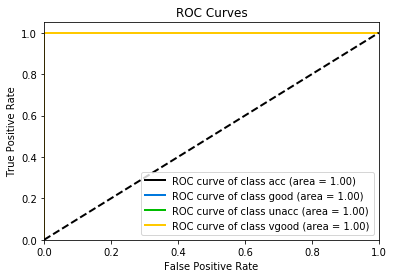

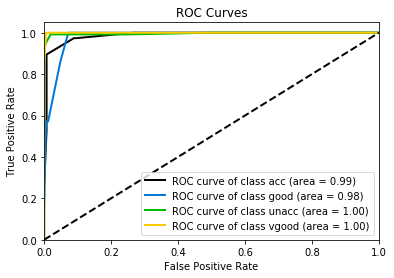

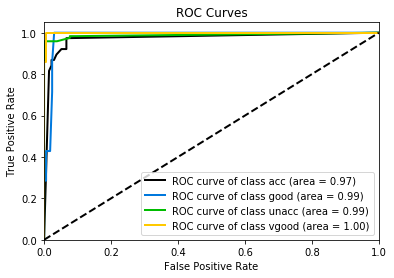

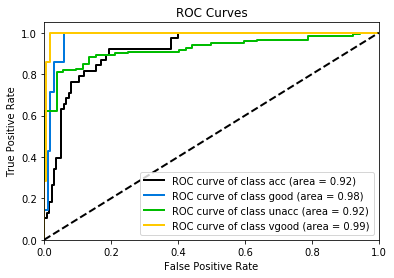

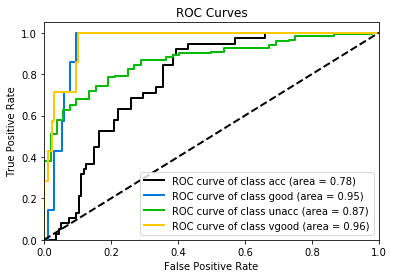

In [67]:
performance_metrix_2 = {}

n = 1
fpr =[]
tpr = []
threshold = []
i=2
y_pred =[]
plot = []
p = []

# Loop for each trial
for m in p_grid.values():
    non_nested_scores = np.zeros(NUM_TRIALS)
    nested_scores = np.zeros(NUM_TRIALS)
    


    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=m["model"], param_grid=m["hyperparam"], cv=inner_cv)
    clf.fit(X_train,y_train)
    non_nested_scores = clf.best_score_

   # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_train, y=y_train, cv=outer_cv)
    nested_scores = nested_score.mean() 
    y_pred = clf.predict(X_test)
    

    performance_metrix_2[n] = {"Non_nested_scores" : non_nested_scores, 
                              "Nested_scores" : nested_scores,
                          "Score_Diff" : non_nested_scores - nested_score,
                             "BEST_PARAM" : clf.best_params_,"Accuracy": clf.best_score_,
                              "BEST_MODEL" : clf.best_estimator_,
                             "Testing_accuracy":  accuracy_score(y_test, y_pred),
                            "performance" :{'F1-Score': metrics.f1_score(y_test, y_pred,average = 'micro'),
     'Precision': metrics.precision_score(y_test, y_pred,average = 'micro' ),
     'Recall': metrics.recall_score(y_test, y_pred,average = 'micro'),
     'Accuracy': metrics.accuracy_score(y_test, y_pred),
     'Kappa Score': metrics.cohen_kappa_score(y_test, y_pred)}}
    n=n+1 
    skplt.metrics.plot_roc(y_test, clf.predict_proba(X_test), plot_micro=False, plot_macro=False)
    plt.title(str(m["model"])[:3])

In [ ]:
matrix2 = {"SVM": performance_metrix_2[1]["performance"],
          "KNN": performance_metrix_2[2]["performance"],
          "Decision Tree": performance_metrix_2[3]["performance"],
          "Logistic": performance_metrix_2[4]["performance"],
         "Naive Bayes": performance_metrix_2[5]["performance"]}
matrix = {"Numeric variable Modeling": matrix1,"Categorical variable Modeling": matrix2 }
measuring_martix = pd.DataFrame(data = matrix)
measuring_martix

From the  final comparison, we can see that SVM for Categorical data comes out as the best algorithm for our case dominating all the performance criterions.